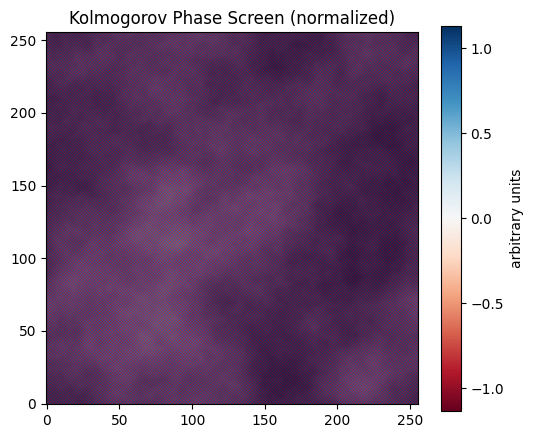

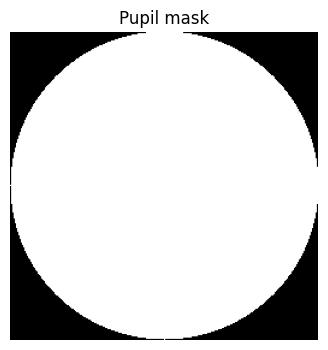

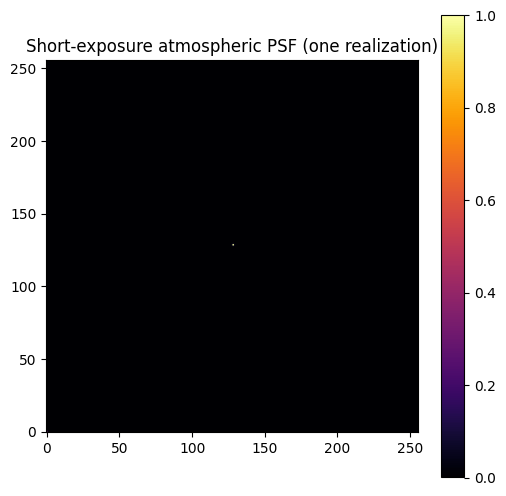

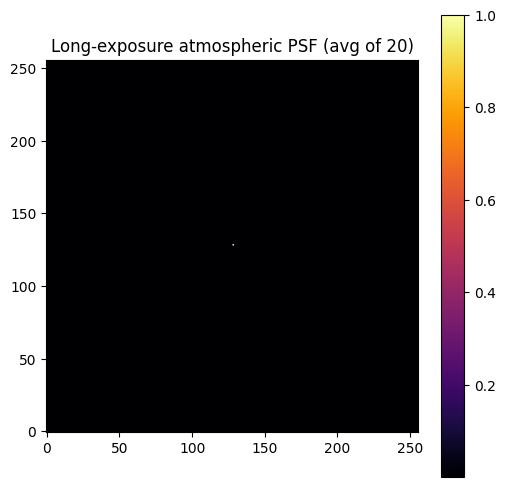

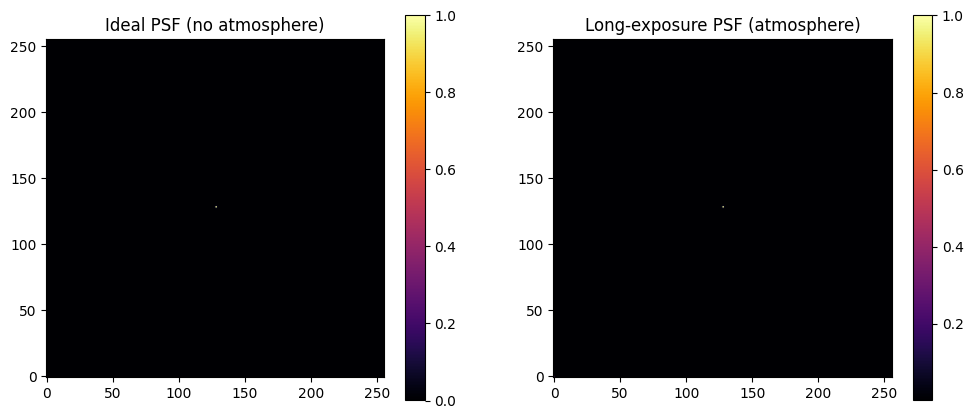

In [1]:
# Atmospheric turbulence: Kolmogorov phase screen -> short & long exposure PSFs
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifft2, fft2

# ---------- PARAMETERS ----------
N = 256                 # grid size (use 256 or 512)
D = 0.2                 # telescope pupil diameter (m) — used only for scaling conceptually
pixel_scale = 1.0       # arbitrary spatial units in pupil plane (we use normalized coords)
r0 = 0.10               # Fried parameter (m). smaller -> worse seeing. try 0.05, 0.1, 0.2
L0 = 10.0               # outer scale (m) — not used heavily here but kept for completeness
wavelength = 550e-9     # observation wavelength (m)
num_realizations = 20   # number of independent phase screens for long exposure

# ---------- BUILD FREQUENCY GRID ----------
fx = np.fft.fftfreq(N, d=1.0/N)   # normalized frequency coordinates
fx, fy = np.meshgrid(fx, fx)
f = np.sqrt(fx**2 + fy**2)
f[0,0] = 1e-6   # avoid singularity at zero freq

# ---------- KOLMOGOROV POWER SPECTRUM (Von Karman approximate) ----------
# power ~ 0.023 * r0^(-5/3) * (f^2 + 1/L0^2)^(-11/6)  (we drop constants, normalize later)
P = (f**2 + (1.0/L0)**2)**(-11/6.0)
# scale by r0: stronger turbulence for smaller r0
P *= 0.023 * (1.0 / (r0**(5.0/3.0)))

# ---------- GENERATE A SINGLE PHASE SCREEN ----------
def make_phase_screen():
    # random complex numbers with amplitude sqrt(P) and random phase
    cn = (np.random.normal(size=(N,N)) + 1j * np.random.normal(size=(N,N))) 
    fourier_field = cn * np.sqrt(P)
    # inverse FFT to get phase in pupil plane
    phase = np.real(ifft2(fftshift(fourier_field)))
    # normalize to have RMS ~ 1 (we will scale by desired amplitude)
    phase = phase - np.mean(phase)
    phase = phase / np.std(phase)
    return phase

# Test: create and show one phase screen
phase0 = make_phase_screen()
plt.figure(figsize=(6,5))
plt.imshow(phase0, cmap='RdBu', origin='lower')
plt.title("Kolmogorov Phase Screen (normalized)")
plt.colorbar(label="arbitrary units")
plt.show()

# ---------- PUPIL (circular) ----------
y, x = np.indices((N, N))
cx = N//2; cy = N//2
r = np.sqrt((x-cx)**2 + (y-cy)**2)
pupil = (r <= (N//2)).astype(float)

plt.figure(figsize=(4,4))
plt.imshow(pupil, cmap='gray', origin='lower')
plt.title("Pupil mask")
plt.axis('off')
plt.show()

# ---------- FUNCTION: PSF FROM PHASE SCREEN ----------
def psf_from_phase(phase, pupil):
    """Apply phase to pupil and compute PSF (intensity) via FFT of complex pupil."""
    complex_pupil = pupil * np.exp(1j * phase)
    amp = fftshift(fft2(complex_pupil))
    intensity = np.abs(amp)**2
    intensity /= intensity.max()
    return intensity

# short-exposure PSF (single realization)
phase_scaled = phase0 * 0.5   # scale amplitude: change to see stronger/weaker turbulence
psf_short = psf_from_phase(phase_scaled, pupil)

plt.figure(figsize=(6,6))
plt.imshow(psf_short, cmap='inferno', origin='lower')
plt.title("Short-exposure atmospheric PSF (one realization)")
plt.colorbar()
plt.show()

# ---------- LONG-EXPOSURE PSF (average of many independent realizations) ----------
psf_sum = np.zeros((N,N))
for i in range(num_realizations):
    ph = make_phase_screen()
    # scale ph to realistic strength (you can tie scaling to wavelength/r0 if desired)
    ph_scaled = ph * 0.5  
    psf_sum += psf_from_phase(ph_scaled, pupil)

psf_long = psf_sum / num_realizations
psf_long /= psf_long.max()

plt.figure(figsize=(6,6))
plt.imshow(psf_long, cmap='inferno', origin='lower')
plt.title(f"Long-exposure atmospheric PSF (avg of {num_realizations})")
plt.colorbar()
plt.show()

# ---------- Compare ideal PSF (diffraction-limited) vs long-exposure ----------
# Ideal (diffraction-limited) from pupil only (no phase)
psf_ideal = psf_from_phase(np.zeros_like(phase0), pupil)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(psf_ideal, cmap='inferno', origin='lower')
plt.title("Ideal PSF (no atmosphere)")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(psf_long, cmap='inferno', origin='lower')
plt.title("Long-exposure PSF (atmosphere)")
plt.colorbar()
plt.show()

Atmosphere cell: N=256, r0=0.1, realizations=20


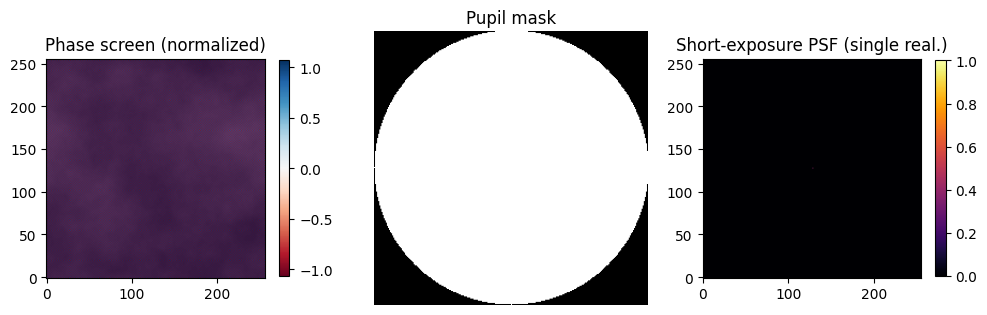

Single phase+PSF generated in 0.91s


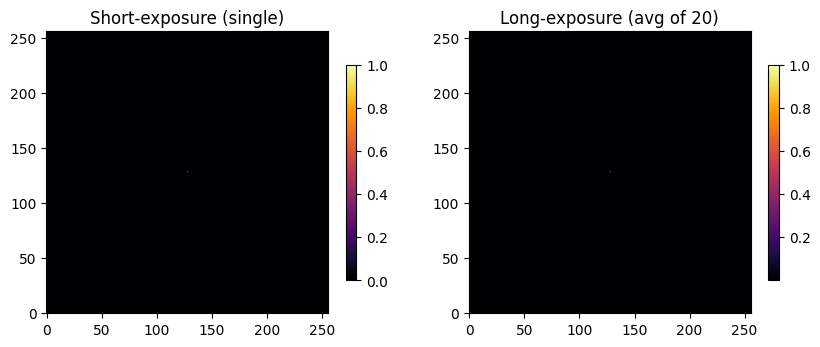

Long-exposure computed in 1.35s
Saved: psf_atm_short.fits, psf_atm_long.fits, pupil_mask.fits


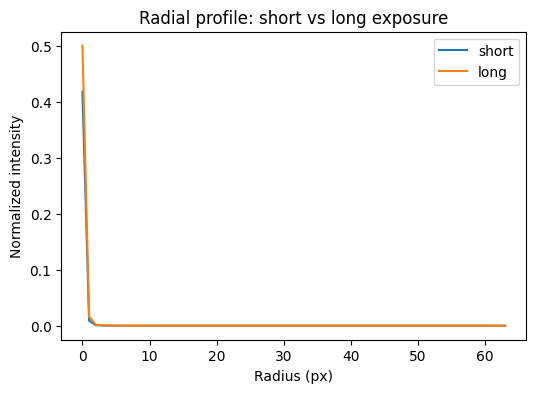

Atmosphere cell finished. Shapes:
phase0: (256, 256) psf_short: (256, 256) psf_long: (256, 256)


In [1]:
# ==========================
# ATMOSPHERE: Kolmogorov Phase Screens + PSFs
# Add this as a new cell at the end of 04-atmosphere.ipynb
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import zoom
from astropy.io import fits
import time

# ----- Parameters (tweak for speed/quality) -----
N = 256                 # grid size for pupil & phase (256 or 512)
r0 = 0.10               # Fried parameter in meters (0.05-0.2 typical)
L0 = 10.0               # outer scale (m) - affects low freq content
wavelength = 550e-9     # wavelength (m) - informational for scaling
num_realizations = 20   # average over this many to get long-exposure PSF
phase_scale = 1.0       # multiply normalized phase by this to control strength
save_fits = True        # save some outputs as FITS for later notebooks

print(f"Atmosphere cell: N={N}, r0={r0}, realizations={num_realizations}")

# ----- Frequency grid (normalized) -----
fx = np.fft.fftfreq(N, d=1.0/N)
FX, FY = np.meshgrid(fx, fx)
F = np.sqrt(FX**2 + FY**2)
F[0,0] = 1e-6  # avoid singularity

# ----- Von-Karman / Kolmogorov power spectral density (unnormalized) -----
# P(f) ~ (f^2 + 1/L0^2)^(-11/6)
P = (F**2 + (1.0 / L0)**2)**(-11/6.0)
# scale by r0 so smaller r0 => stronger turbulence (we keep normalization later)
P *= 0.023 * (1.0 / (r0**(5.0/3.0)))

# ----- phase screen generator -----
def make_phase_screen(seed=None):
    if seed is not None:
        np.random.seed(seed)
    cn = (np.random.normal(size=(N,N)) + 1j * np.random.normal(size=(N,N)))
    fourier_field = cn * np.sqrt(P)
    # inverse fftshift + ifft to get real-space phase (center conventions)
    field = np.fft.ifft2(ifftshift(fourier_field))
    phase = np.real(field)
    # normalize (zero mean, unit std) so scaling by phase_scale is simple
    phase = (phase - phase.mean()) / (phase.std() + 1e-12)
    return phase

# ----- pupil mask (circular) -----
y, x = np.indices((N, N))
cx = N // 2; cy = N // 2
r = np.sqrt((x - cx)**2 + (y - cy)**2)
pupil = (r <= (N // 2)).astype(float)

# ----- PSF from phase screen (complex pupil FFT) -----
def psf_from_phase(phase, pupil_mask=pupil):
    complex_pupil = pupil_mask * np.exp(1j * (phase * phase_scale))
    amp = fftshift(fft2(complex_pupil))
    intensity = np.abs(amp)**2
    intensity /= (intensity.max() + 1e-16)
    return intensity

# ----- show one sample phase screen + short-exposure PSF -----
t0 = time.time()
phase0 = make_phase_screen()
psf_short = psf_from_phase(phase0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(phase0, cmap='RdBu', origin='lower')
plt.title("Phase screen (normalized)")
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.imshow(pupil, cmap='gray', origin='lower')
plt.title("Pupil mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(psf_short, cmap='inferno', origin='lower')
plt.title("Short-exposure PSF (single real.)")
plt.colorbar(shrink=0.7)
plt.show()
print("Single phase+PSF generated in {:.2f}s".format(time.time() - t0))

# ----- build long-exposure PSF by averaging independent realizations -----
t1 = time.time()
psf_accum = np.zeros((N, N), dtype=float)
for i in range(num_realizations):
    ph = make_phase_screen(seed=None)
    psf_accum += psf_from_phase(ph)
psf_long = psf_accum / num_realizations
psf_long /= (psf_long.max() + 1e-16)  # normalize

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(psf_short, cmap='inferno', origin='lower')
plt.title("Short-exposure (single)")
plt.colorbar(shrink=0.7)

plt.subplot(1,2,2)
plt.imshow(psf_long, cmap='inferno', origin='lower')
plt.title(f"Long-exposure (avg of {num_realizations})")
plt.colorbar(shrink=0.7)
plt.show()
print("Long-exposure computed in {:.2f}s".format(time.time() - t1))

# ----- optionally save outputs (FITS) for later notebooks -----
if save_fits:
    fits.writeto("psf_atm_short.fits", psf_short.astype(np.float32), overwrite=True)
    fits.writeto("psf_atm_long.fits", psf_long.astype(np.float32), overwrite=True)
    fits.writeto("pupil_mask.fits", pupil.astype(np.float32), overwrite=True)
    print("Saved: psf_atm_short.fits, psf_atm_long.fits, pupil_mask.fits")

# ----- produce a small 2D radial profile comparison (optional quick metric) -----
def radial_profile(img):
    cx = img.shape[0]//2
    y, x = np.indices(img.shape)
    r = np.sqrt((x-cx)**2 + (y-cx)**2).astype(np.int32)
    t = np.bincount(r.ravel(), img.ravel())
    n = np.bincount(r.ravel())
    radial = t / (n + 1e-12)
    return radial

rp_short = radial_profile(psf_short)
rp_long = radial_profile(psf_long)

plt.figure(figsize=(6,4))
plt.plot(rp_short[:N//4], label='short')
plt.plot(rp_long[:N//4], label='long')
plt.xlabel("Radius (px)")
plt.ylabel("Normalized intensity")
plt.legend()
plt.title("Radial profile: short vs long exposure")
plt.show()

# ----- done -----
print("Atmosphere cell finished. Shapes:")
print("phase0:", phase0.shape, "psf_short:", psf_short.shape, "psf_long:", psf_long.shape)
